### Import Packages

In [1]:
import pandas as pd
import math
from google.cloud import storage


### Read in data

In [2]:
client = storage.Client(project="uk-election-406413")
bucket = client.bucket("ukelectiondata")
files = bucket.list_blobs()
file_names = [file.name for file in files]

election_results = bucket.blob("preprocessed_final_df.csv")
election_results.download_to_filename('C:\\Users\\wg4618\\Documents\\LeWagon\\preprocessed_final_df.csv')


### Prepare data

In [3]:
elections_polling_df = pd.read_csv('C:\\Users\\wg4618\\Documents\\LeWagon\\preprocessed_final_df.csv')
elections_polling_df.drop(elections_polling_df.columns[0], axis=1, inplace=True)


In [4]:
elections_polling_df['con_pre_ge_adjusted'] = elections_polling_df['con_share_prev']/elections_polling_df['mean_con_share_ge']*elections_polling_df['con_pre_ge_poll']
elections_polling_df['lab_pre_ge_adjusted'] = elections_polling_df['lab_share_prev']/elections_polling_df['mean_lab_share_ge']*elections_polling_df['lab_pre_ge_poll']
elections_polling_df['lib_pre_ge_adjusted'] = elections_polling_df['lib_share_prev']/elections_polling_df['mean_lib_share_ge']*elections_polling_df['lib_pre_ge_poll']
elections_polling_df['oth_pre_ge_adjusted'] = elections_polling_df['oth_share_prev']/elections_polling_df['mean_oth_share_ge']*elections_polling_df['oth_pre_ge_poll']

elections_polling_df.columns


Index(['constituency_id', 'year', '0-9', '10-19', '20-29', '30-39', '40-49',
       '50-59', '60-69', '70-79', '80+', 'Home_owners', 'Private_renters',
       'Social_renters', 'Asian', 'Black', 'Mixed', 'Other', 'White',
       'country/region', 'total_votes', 'con_votes', 'lab_votes', 'lib_votes',
       'oth_votes', 'con_share', 'lab_share', 'lib_share', 'oth_share',
       'con_share_prev', 'lab_share_prev', 'lib_share_prev', 'oth_share_prev',
       'mean_con_share_ge', 'mean_lab_share_ge', 'mean_lib_share_ge',
       'mean_oth_share_ge', 'con_pre_ge_poll', 'lab_pre_ge_poll',
       'lib_pre_ge_poll', 'oth_pre_ge_poll', 'con_pre_ge_adjusted',
       'lab_pre_ge_adjusted', 'lib_pre_ge_adjusted', 'oth_pre_ge_adjusted'],
      dtype='object')

In [5]:
con_app = 0.25
lab_app = 0.44
lib_app = 0.10
oth_app = 0.21


In [20]:
melted_df = pd.melt(elections_polling_df, id_vars=['constituency_id', 'year', 'Private_renters', 'Social_renters', #'Home_owners',
                                   '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', #'80+',
                                   'White', 'Asian', 'Black', 'Mixed', #'Other',
                                   'con_pre_ge_adjusted', 'lab_pre_ge_adjusted', 'lib_pre_ge_adjusted', 'oth_pre_ge_adjusted',
                                   'con_share_prev','mean_con_share_ge', 'lab_share_prev','mean_lab_share_ge', 'lib_share_prev','mean_lib_share_ge', 'oth_share_prev', 'mean_oth_share_ge'],
                    value_vars=['con_votes', 'lab_votes', 'lib_votes', 'oth_votes'],
                    var_name='party', value_name='votes')

melted_df.to_csv('final_df.csv', index=False)

columns_to_drop = ["year", "constituency_id", "votes", 'con_share_prev','mean_con_share_ge', 'lab_share_prev','mean_lab_share_ge', 'lib_share_prev','mean_lib_share_ge', 'oth_share_prev', 'mean_oth_share_ge']
X_old = melted_df[melted_df['year'] != 2024].drop(columns=columns_to_drop)

X_new = melted_df[melted_df['year'] == 2024]
X_new['con_pre_ge_adjusted'] = X_new['con_share_prev']/X_new['mean_con_share_ge']*con_app
X_new['lab_pre_ge_adjusted'] = X_new['lab_share_prev']/X_new['mean_lab_share_ge']*lab_app
X_new['lib_pre_ge_adjusted'] = X_new['lib_share_prev']/X_new['mean_lib_share_ge']*lib_app
X_new['oth_pre_ge_adjusted'] = X_new['oth_share_prev']/X_new['mean_oth_share_ge']*oth_app

X_new.drop(columns=columns_to_drop, inplace=True)

y_old = melted_df[["votes"]][melted_df['year'] != 2024]


/tmp/ipykernel_21270/748891908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['con_pre_ge_adjusted'] = X_new['con_share_prev']/X_new['mean_con_share_ge']*con_app
/tmp/ipykernel_21270/748891908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new['lab_pre_ge_adjusted'] = X_new['lab_share_prev']/X_new['mean_lab_share_ge']*lab_app
/tmp/ipykernel_21270/748891908.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

### Encode the data

In [7]:
column_to_encode = 'party'
one_hot_encoded = pd.get_dummies(X_old[column_to_encode], prefix=column_to_encode)
X_old_encoded = pd.concat([X_old, one_hot_encoded], axis=1)
X_old_encoded = X_old_encoded.drop(column_to_encode, axis=1)

one_hot_encoded2 = pd.get_dummies(X_new[column_to_encode], prefix=column_to_encode)
X_new_encoded = pd.concat([X_new, one_hot_encoded2], axis=1)
X_new_encoded = X_new_encoded.drop(column_to_encode, axis=1)

X_new_encoded.head()


,Private_renters,Social_renters,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,...,Black,Mixed,con_pre_ge_adjusted,lab_pre_ge_adjusted,lib_pre_ge_adjusted,oth_pre_ge_adjusted,party_con_votes,party_lab_votes,party_lib_votes,party_oth_votes
4,0.162862,0.204490,0.1028,0.1242,0.1302,0.1330,0.1188,0.1294,0.1236,0.0934,...,0.005276,0.014610,0.120476,0.721092,0.031356,0.343272,1,0,0,0
9,0.190187,0.122266,0.0804,0.1048,0.1092,0.1066,0.1000,0.1390,0.1436,0.1376,...,0.002579,0.011162,0.269609,0.532107,0.052567,0.131433,1,0,0,0
14,0.220152,0.156054,0.1266,0.1190,0.1028,0.1424,0.1422,0.1504,0.1024,0.0858,...,0.026223,0.026952,0.341544,0.314975,0.132802,0.057212,1,0,0,0
19,0.117259,0.155086,0.1094,0.1156,0.1038,0.1222,0.1128,0.1514,0.1134,0.1022,...,0.021581,0.025661,0.414063,0.273425,0.055334,0.043296,1,0,0,0
24,0.144238,0.111398,0.1210,0.1456,0.0862,0.1098,0.1462,0.1428,0.1040,0.1070,...,0.018544,0.035446,0.280721,0.493237,0.101446,0.063397,1,0,0,0


### Split the data

In [8]:
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_old_encoded, y_old, test_size=0.2, random_state=42)


### Grid search and find best model

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

gb_classifier = GradientBoostingRegressor()

param_grid = {'n_estimators': [60, 100, 140],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [6, 7, 8]}

grid_search_tree = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search_tree.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search_tree.best_params_)

best_model_gb = grid_search_tree.best_estimator_

y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse = ", mse)
print("r2_score = ", r2)


/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/willgreen93/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemb

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 60}
mse =  7468767.503340284
r2_score =  0.9189250297668066


<AxesSubplot:ylabel='votes'>

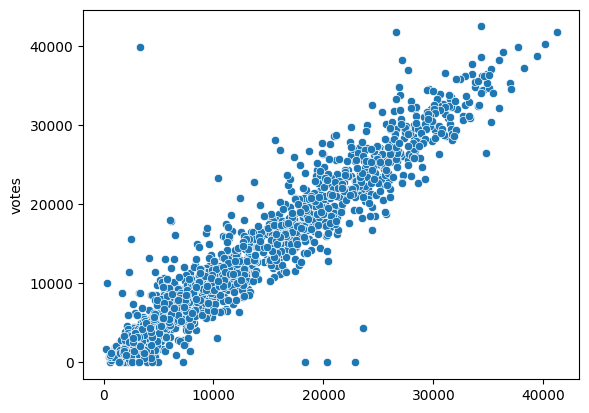

In [18]:
import seaborn as sns

sns.scatterplot(x=y_pred, y=y_test['votes'])


### Predict next election

In [28]:
y_new = best_model_gb.predict(X_new_encoded)
X_new_predicted = X_new
X_new_predicted["votes"] = y_new
X_new_predicted["constituency_id"] = melted_df[melted_df['year']==2024]["constituency_id"]

X_new_min = X_new_predicted[["constituency_id", "party", "votes"]]
X_new_min2 = X_new_min.pivot(index='constituency_id', columns='party', values='votes')

X_new_min2['winning_party'] = X_new_min2.idxmax(axis=1)
X_new_min2


/tmp/ipykernel_21270/1087918527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new_predicted["votes"] = y_new
/tmp/ipykernel_21270/1087918527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new_predicted["constituency_id"] = melted_df[melted_df['year']==2024]["constituency_id"]


party,con_votes,lab_votes,lib_votes,oth_votes,winning_party
constituency_id,,,,,
E14000530,17683.056862,17905.278579,5892.533454,4538.633623,lab_votes
E14000531,21776.613011,12356.754979,3343.452993,5955.323890,con_votes
E14000532,12707.982518,23165.489454,4164.507220,4683.639294,lab_votes
E14000533,19618.039867,16776.189593,2531.640163,5027.804638,con_votes
E14000534,18805.104692,12058.336411,12142.413788,5214.628203,con_votes
...,...,...,...,...,...
W07000076,6303.202066,22535.510087,1061.068307,13402.151651,lab_votes
W07000077,7004.783453,21466.707290,-103.458272,11446.399363,lab_votes
W07000078,14244.676613,25329.984220,1715.523061,3222.177405,lab_votes


In [ ]:
X_new_min2.idxmax(axis=1).value_counts()
